# Predicting the 2022 FIFA World Cup
<br>

    
#### Chris Santiago
#### Satyar Foroughi
#### Arshia Pessaran
#### Jordan Hatfield

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Data Exploration and Limitations

Before we make any predictions, let's explore the data. Throughout history, these are the teams that have performed best in the FIFA World Cup. 

In [2]:
world_cups_df = pd.read_csv('WorldCups.csv')

winners_ser = world_cups_df['Winner'].value_counts()
runnersup_ser = world_cups_df['Runners-Up'].value_counts()
thirdplace_ser = world_cups_df['Third'].value_counts()

country_placers_df = pd.concat([winners_ser, runnersup_ser, thirdplace_ser], axis=1)
country_placers_df.fillna(0, inplace=True)
country_placers_df = country_placers_df.astype(int)
country_placers_df

Winner  Runners-Up  Third
Brazil               5           2      2
Italy                4           2      1
Germany FR           3           3      1
Uruguay              2           0      0
Argentina            2           3      0
Germany              1           1      3
England              1           0      0
France               1           1      2
Spain                1           0      0
Netherlands          0           3      1
Czechoslovakia       0           2      0
Hungary              0           2      0
Sweden               0           1      2
Poland               0           0      2
Chile                0           0      1
Croatia              0           0      1
Portugal             0           0      1
Turkey               0           0      1
Austria              0           0      1
USA                  0           0      1

We can easily discern from the graph that Brazil has consistently performed the best out of all teams, followed by Italy and Germany (including the period of the German Federal Republic).

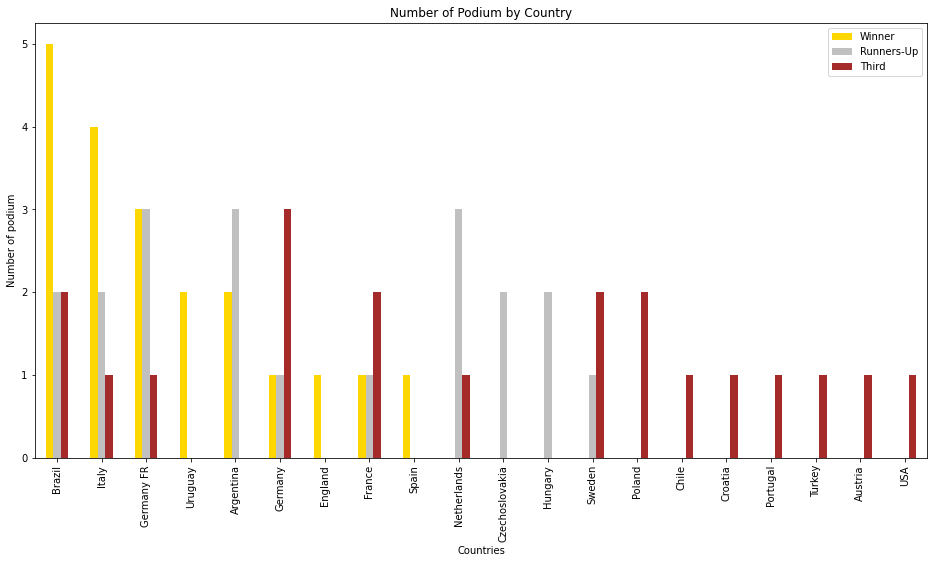

In [3]:
country_placers_df.plot(kind='bar', figsize=(16,8), color=['gold', 'silver', 'brown'])
plt.xlabel("Countries")
plt.ylabel("Number of podium")
plt.title("Number of Podium by Country");

The limitation here is the world cup data isn't sufficient. Teams play a multitude of matches across years between world cups. We are therefore missing out on valuable data.

We found a more appropriate dataset, which includes 44,150 results of international football matches starting from the very first official match in 1872 up to 2022. The matches range from FIFA World Cup to FIFI Wild Cup to regular friendly matches.

Using this new dataset, the graph below illustrates the distribution of games played by match type.

### Variable Descriptions
* date - date of the match
* home_team - the name of the home team
* away_team - the name of the away team
* home_score - full-time home team score including extra time, not including penalty-shootouts
* away_score - full-time away team score including extra time, not including penalty-shootouts
* tournament - the name of the tournament
* city - the name of the city/town/administrative unit where the match was played
* country - the name of the country where the match was played
* neutral - TRUE/FALSE column indicating whether the match was played at a neutral venue

In [4]:
df = pd.read_csv("results.csv")
# home_team and away_team were changed to team1 and team2 for simplification.
df = df.rename(columns={"home_team":"team1", "away_team":"team2", "home_score":"team1_score",
                        "away_score":"team2_score"})
df.head()

date     team1     team2  team1_score  team2_score tournament  \
0  1872-11-30  Scotland   England          0.0          0.0   Friendly   
1  1873-03-08   England  Scotland          4.0          2.0   Friendly   
2  1874-03-07  Scotland   England          2.0          1.0   Friendly   
3  1875-03-06   England  Scotland          2.0          2.0   Friendly   
4  1876-03-04  Scotland   England          3.0          0.0   Friendly   

      city   country  neutral  
0  Glasgow  Scotland    False  
1   London   England    False  
2  Glasgow  Scotland    False  
3   London   England    False  
4  Glasgow  Scotland    False

Another limitation we encountered was some games ended in a draw in later rounds of the World Cup. 
In the real world, the game would be determined by penalty shootouts. Instead of choosing a winner at random, we used a dataset containing all the penalty shootouts. We'll explain more about this later.

In [5]:
penalties = pd.read_csv("shootouts.csv")
penalties = penalties.rename(columns={"home_team":"team1", "away_team":"team2"})
penalties.head()

date        team1             team2       winner
0  1967-08-22        India            Taiwan       Taiwan
1  1971-11-14  South Korea  Vietnam Republic  South Korea
2  1972-05-17     Thailand       South Korea  South Korea
3  1972-05-19     Thailand          Cambodia     Thailand
4  1973-04-21      Senegal             Ghana        Ghana

In [6]:
# checking for any missing values in the columns
df.isnull().sum()

date            0
team1           0
team2           0
team1_score    48
team2_score    48
tournament      0
city            0
country         0
neutral         0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()

date           0
team1          0
team2          0
team1_score    0
team2_score    0
tournament     0
city           0
country        0
neutral        0
dtype: int64

To see how our data is distributed, we made a graph to illustrate the types of matches and how many were played in each category.

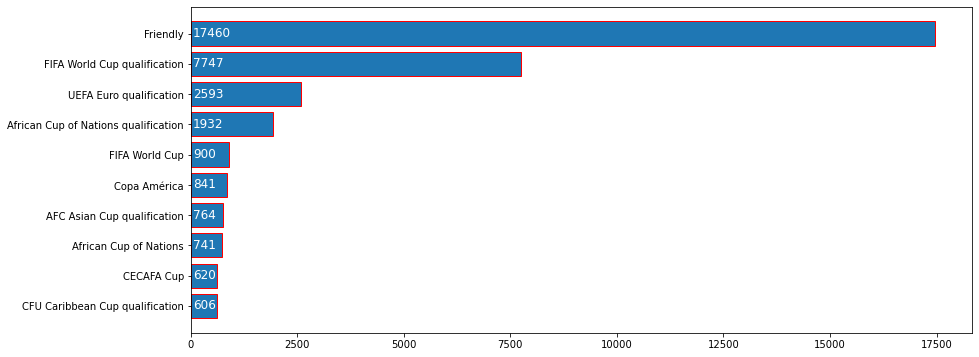

In [9]:
match_types = 10
axis = df.tournament.value_counts()[:match_types].sort_values()
value = axis.values
label = axis.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="r")
for i in range(match_types):
    plt.text(x=50,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()

Initially, we wanted to exclude Friendly games since team performance more volatile when it is a high pressure match. However, we can notice in the graph that the majority of the data consists of Friendly matches, and we didn't want to remove such a significant sample of the data.

 <br>
  <br>
These are the teams that qualified for the World Cup and the respective groups they were placed in.

In [10]:
qualifiers = ["Qatar","Ecuador","Senegal","Netherlands","England","Iran","United States","Wales",
              "Argentina","Saudi Arabia","Mexico","Poland","France","Australia","Denmark","Tunisia",
              "Spain","Costa Rica","Germany","Japan","Belgium","Canada","Morocco","Croatia",
              "Brazil","Serbia","Switzerland","Cameroon","Portugal","Ghana","Uruguay","South Korea"]

Group_A= ["Qatar","Ecuador","Senegal","Netherlands"]
Group_B= ["England","Iran","United States","Wales"]
Group_C= ["Argentina","Saudi Arabia","Mexico","Poland"]
Group_D= ["France","Australia","Denmark","Tunisia"]
Group_E= ["Spain","Costa Rica","Germany","Japan"]
Group_F= ["Belgium","Canada","Morocco","Croatia"]
Group_G= ["Brazil","Serbia","Switzerland","Cameroon"]
Group_H= ["Portugal","Ghana","Uruguay","South Korea"]
Groups={"Group A":Group_A,"Group B":Group_B,"Group C":Group_C,"Group D":Group_D,"Group E":Group_E,
        "Group F":Group_F,"Group G":Group_G,"Group H":Group_H}

## Preprocessing

We tried out the process with two different dataframes, one with only qualified teams, and the other with at least one qualified team.

However, in this presentation we will proceed with only the main dataframe.

In [11]:
# Limiting this dataframe to games where both of the teams playing
# have qualified for the 2022 World Cup.
df_q = df.copy()
df_q = df[df["team1"].isin(qualifiers) & df["team2"].isin(qualifiers)]

# Limiting the main dataframe to games where at least one of the teams playing
# has qualified for the 2022 World Cup.
df = df[df["team1"].isin(qualifiers) | df["team2"].isin(qualifiers)]

With mind of dimensionality, we will drop fields that are mainly categorical, and not specific to World Cup results.

In [12]:
# Getting rid of columns we don't need
df = df.drop(["city","country","neutral","tournament"], axis=1)
df_q = df_q.drop(["city","country","neutral","tournament"], axis=1)

Taking a look at the characteristics of the target variables.

In [13]:
df.agg(
    {
        "team1_score": ["min", "mean", "median", "var", "std", "max", "skew"],
        "team2_score": ["min", "mean", "median", "var", "std", "max", "skew"],
    }
)

team1_score  team2_score
min        0.000000     0.000000
mean       1.715248     1.172533
median     1.000000     1.000000
var        2.835309     1.782380
std        1.683838     1.335058
max       31.000000    17.000000
skew       2.012296     1.920391

Looking at the max values for the scores, we notice some outliers. 
<br>

The record for most goals by one team in a world cup is 13, so we will get rid of any scores above that.

In [14]:
record=13
df=df[(df["team1_score"]<record) & (df["team2_score"]<record)]

# same for "only qualifiers" data frame
df_q=df_q[(df_q["team1_score"]<record) & (df_q["team2_score"]<record)]

df.agg(
    {
        "team1_score": ["min", "mean", "median", "var", "std", "max", "skew"],
        "team2_score": ["min", "mean", "median", "var", "std", "max", "skew"],
    }
)

team1_score  team2_score
min        0.000000     0.000000
mean       1.703772     1.169697
median     1.000000     1.000000
var        2.650211     1.736850
std        1.627947     1.317896
max       12.000000    12.000000
skew       1.460993     1.732600

Before we continue, we will double the dataset by switching team1 and team2, and adding a new match to the dataframe. This is due to the fact that our dataset had "home" and "away" teams which shouldn't matter to our model when predicting the world scores. 

For every game that a team played a home match, we wanted the same match as an away team. For example, if there is match between a England as team1 and USA as team2, we would now have same match with USA as team1 and England as team2.

The following table shows that the team1 and team2 scores are now equivalently distributed, which is what we wanted. Before preprocessing, we had approx. 44,000 observations, and then we filtered it down to approx. 18,500 observations. Our final dataset includes approx. 37,000 observations.

In [15]:
df2 = df.copy()
df2["team1"] = df["team2"]
df2["team2"] = df["team1"]
df2["team1_score"] = df["team2_score"]
df2["team2_score"] = df["team1_score"]

# qualified only
df2_q = df_q.copy()
df2_q["team1"] = df_q["team2"]
df2_q["team2"] = df_q["team1"]
df2_q["team1_score"] = df_q["team2_score"]
df2_q["team2_score"] = df_q["team1_score"]

# Now, we will merge our two dataframes and shuffle the new df to use for machine learning
df_ml = pd.concat([df,df2], axis=0)
df_ml = df_ml.sample(frac=1,random_state=1).reset_index(drop=True)

# qualified only
df_ml_q = pd.concat([df_q,df2_q], axis=0)
df_ml_q = df_ml_q.sample(frac=1,random_state=1).reset_index(drop=True)

df_ml["date"] = pd.DatetimeIndex(df_ml["date"]).year
df_ml = df_ml.rename(columns={"date":"year"})

df_ml_q["date"] = pd.DatetimeIndex(df_ml_q["date"]).year
df_ml_q = df_ml_q.rename(columns={"date":"year"})

df_ml.describe()

year   team1_score   team2_score
count  37066.000000  37066.000000  37066.000000
mean    1987.590083      1.436734      1.436734
std       26.966751      1.504919      1.504919
min     1872.000000      0.000000      0.000000
25%     1973.000000      0.000000      0.000000
50%     1994.000000      1.000000      1.000000
75%     2008.000000      2.000000      2.000000
max     2022.000000     12.000000     12.000000

This graph shows how many matches we have for each team. 

We can see that our dataset isn't perfect since we have a lot of observations for some teams and much less for others. For example, England has a significantly larger amount of matches compared Serbia, but there is a reasonable amount for each team.

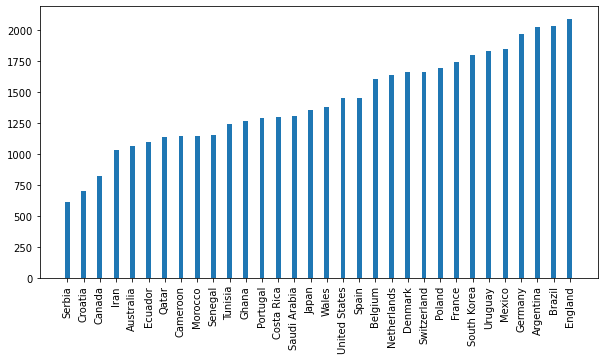

In [16]:
graph = (df_ml.team1.value_counts() + df_ml.team2.value_counts()).sort_values()
graph = graph[graph.index.isin(qualifiers)]

graph_x = graph.index
graph_y = graph.values

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.xticks(rotation="vertical")
plt.bar(height=graph_y, x=graph_x, width=0.3)
plt.show()

Now, we want to find all the countries present in the dataset.

In [17]:
team1s = df.team1.unique()
team2s = df.team2.unique()

countries = np.unique(np.concatenate((team1s,team2s), axis=0))

For a smoother approach to the dataset, we converted the teams to categorical labels.

In [18]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

# We use "countries" if we work with the main dataframe,
# we use qualifiers if we work with the qualifiers only dataframe
label_encoder.fit(countries)
# label_encoder.fit(qualifiers)

df_labeled = df_ml.copy()
# df_labeled = df_ml_q.copy()


df_labeled["team1"] = label_encoder.transform(df_labeled["team1"])
df_labeled["team2"] = label_encoder.transform(df_labeled["team2"])

df_labeled["team1"] = df_labeled["team1"].astype("category")
df_labeled["team2"] = df_labeled["team2"].astype("category")

df_labeled.head()

year team1 team2  team1_score  team2_score
0  2018    95   157          1.0          1.0
1  1921   215   171          1.0          2.0
2  1970    33   187          1.0          2.0
3  2009   209     2          0.0          1.0
4  1979    61   146          5.0          1.0

Now, we split the dataset into training and testing samples.

In [19]:
from sklearn.model_selection import train_test_split

# Making our X, Y and Training and Testing samples
X = df_labeled.iloc[:,0:3]
Y = df_labeled.iloc[:,3:5]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

### Machine Learning model

Since we needed to predict two targets (team1 score and team2 score), this made it challenging to find the right model. We chose the MultiOutputRegressor to deal with having multiple targets. After some trial and error, the RandomForestClassifier function seemed to be the most appropriate estimator.

In [20]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier

model = MultiOutputRegressor(RandomForestClassifier())
model.fit(X_train,Y_train)

MultiOutputRegressor(estimator=RandomForestClassifier())

Next, we look at the performance measures of our model on both the training and testing set.

In [21]:
from sklearn.metrics import classification_report

def reporting(X, Y, model):
    predictions = model.predict(X)
    score_team1 = [score[0] for score in predictions]
    score_team2 = [score[1] for score in predictions]
    
    print("Classification Report Team 1")
    print(classification_report(Y.iloc[:,0], score_team1))
    print("Classification Report Team 2")
    print(classification_report(Y.iloc[:,1], score_team2))
    
    return score_team1, score_team2

In [22]:
print('Training Set')
training_report_team1, training_report_team2 = reporting(X_train, Y_train, model)
print('Testing Set')
testing_report_team1, testing_report_team2 = reporting(X_test, Y_test, model)

Training Set
Classification Report Team 1
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      8575
         1.0       0.90      0.91      0.91      8623
         2.0       0.89      0.87      0.88      5448
         3.0       0.90      0.86      0.88      2625
         4.0       0.90      0.85      0.88      1312
         5.0       0.85      0.84      0.84       574
         6.0       0.88      0.84      0.86       317
         7.0       0.92      0.83      0.87       162
         8.0       0.80      0.85      0.83        92
         9.0       0.95      0.84      0.89        44
        10.0       0.85      0.79      0.81        14
        11.0       0.88      1.00      0.93         7
        12.0       0.86      1.00      0.92         6

    accuracy                           0.90     27799
   macro avg       0.88      0.88      0.88     27799
weighted avg       0.90      0.90      0.90     27799

Classification Report Team 2
        

Our classifcation report shows our model performs significantly better on the training set with a 90% accuracy, however the accuracy drops to 30% on the testing set. This is likely due to overfitting. We will try to enhance model performance with hyperparameter tuning. 

<br>

To fix this we tried cross-validation.

In [23]:
# The cell below takes long to compute. Est: 5-8 minutes
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14,16]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,10]
# Create the random grid
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,}

rf_randomcv=RandomizedSearchCV(estimator=model,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
# fit to randomized rf
rf_randomcv.fit(X_train,Y_train)

# to see best parameters
print(rf_randomcv.best_params_)
print("\n")
# to make new classifier with the best estimator
best_random_grid=rf_randomcv.best_estimator_
print(best_random_grid)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.9min finished


{'estimator__n_estimators': 800, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 60}


MultiOutputRegressor(estimator=RandomForestClassifier(max_depth=60,
                                                      min_samples_split=10,
                                                      n_estimators=800))


In [24]:
best_random_grid.fit(X_train, Y_train)

MultiOutputRegressor(estimator=RandomForestClassifier(max_depth=60,
                                                      min_samples_split=10,
                                                      n_estimators=800))

In [25]:
print('Training Set')
training_score_team1, training_score_team2 = reporting(X_train, Y_train, best_random_grid)
print('Testing Set')
testing_score_team1, testing_score_team2 = reporting(X_test, Y_test, best_random_grid)

Training Set
Classification Report Team 1
              precision    recall  f1-score   support

         0.0       0.72      0.87      0.79      8575
         1.0       0.68      0.85      0.76      8623
         2.0       0.73      0.62      0.67      5448
         3.0       0.78      0.36      0.49      2625
         4.0       0.76      0.25      0.38      1312
         5.0       0.73      0.15      0.25       574
         6.0       0.76      0.15      0.25       317
         7.0       0.83      0.12      0.22       162
         8.0       1.00      0.07      0.12        92
         9.0       1.00      0.02      0.04        44
        10.0       0.00      0.00      0.00        14
        11.0       1.00      0.14      0.25         7
        12.0       0.00      0.00      0.00         6

    accuracy                           0.71     27799
   macro avg       0.69      0.28      0.32     27799
weighted avg       0.72      0.71      0.68     27799

Classification Report Team 2
        

In the classification report after we performed cross-validation, the model accuracy on the testing slightly improved by about 3%. 

Keep in mind that scores can vary a lot, but the games have only three possible outcomes: win, lose, draw.
<br>
<br>


Let's add these three outcomes as one variable to our model and predictions, then see again how accurate our model is for predicting the outcome of the games.

In [26]:
# adding outcome to testing sample and predictions

len_testing = len(testing_score_team1)
resault_testing=[]
resault_Y_test=[]
list_Y_test1=list(Y_test.team1_score)
list_Y_test2=list(Y_test.team2_score)


for i in range(len_testing):
    resault_testing.append(testing_score_team1[i]-testing_score_team2[i])
    if (resault_testing[i]>0):
        resault_testing[i]=1
    elif (resault_testing[i]<0):
        resault_testing[i]=-1
        
for i in range(len_testing):
    resault_Y_test.append(list_Y_test1[i]-list_Y_test2[i])
    if (resault_Y_test[i]>0):
        resault_Y_test[i]=1
    elif (resault_Y_test[i]<0):
        resault_Y_test[i]=-1

In [27]:
# adding outcome to training sample and predictions

len_training = len(training_score_team1)
resault_training=[]
resault_Y_train=[]
list_Y_train1=list(Y_train.team1_score)
list_Y_train2=list(Y_train.team2_score)


for i in range(len_training):
    resault_training.append(training_score_team1[i]-training_score_team2[i])
    if (resault_training[i]>0):
        resault_training[i]=1
    elif (resault_training[i]<0):
        resault_training[i]=-1
        
for i in range(len_training):
    resault_Y_train.append(list_Y_train1[i]-list_Y_train2[i])
    if (resault_Y_train[i]>0):
        resault_Y_train[i]=1
    elif (resault_Y_train[i]<0):
        resault_Y_train[i]=-1

In [28]:
# adding outcome to our machine learning dataframe

len_matches = len(df_ml.team1)
resault=[]
for i in range(len_matches):
    resault.append(df_ml.team1_score[i]-df_ml.team2_score[i])
    if (resault[i]>0):
        resault[i]=1
    elif (resault[i]<0):
        resault[i]=-1

In [29]:
df_ml["resault"]=resault

In [30]:
training_WINSreport_team1=classification_report(resault_Y_train,resault_training)
print(training_WINSreport_team1)

              precision    recall  f1-score   support

        -1.0       0.77      0.69      0.72     10627
         0.0       0.51      0.69      0.59      6522
         1.0       0.77      0.69      0.73     10650

    accuracy                           0.69     27799
   macro avg       0.69      0.69      0.68     27799
weighted avg       0.71      0.69      0.70     27799



In [31]:
testing_WINSreport_team1=classification_report(resault_Y_test,resault_testing)
print(testing_WINSreport_team1)

              precision    recall  f1-score   support

        -1.0       0.53      0.44      0.48      3565
         0.0       0.24      0.36      0.28      2160
         1.0       0.51      0.44      0.47      3542

    accuracy                           0.42      9267
   macro avg       0.43      0.41      0.41      9267
weighted avg       0.45      0.42      0.43      9267



The accuracy for predicting wins on training is still better than testing, but the overall accuracy improved. This indicates that our model does a better job of predicting the outcome of the game, than predicitng the actual scores. This was expected.

### Predictions

We made a custom function to predict win, lose, or draw, which we will use for the group stage of the World Cup.

In [32]:
# function to find who wins when given model prediction
def who_wins(predicted):
    if (predicted[0][0]>predicted[0][1]):
        return 0
    elif (predicted[0][0]<predicted[0][1]):
        return 1
    else:
        return 2

This is a sample prediction to demonstrate how the function works.

In [33]:
# sample predictions
team1="Wales"
team2="Iran"
year=2022

teamss=[team1,team2]
team1_labeled=label_encoder.transform([team1])[0]
team2_labeled=label_encoder.transform([team2])[0]

X_sample=np.array([[year,team1_labeled,team2_labeled]])
sample_out = model.predict(X_sample)
winner=who_wins(sample_out)

try:
    print("winner is %s score:%d-%d" %(teamss[winner],sample_out[0][0],sample_out[0][1]))
except IndexError:
    print("match is draw score: %d-%d" %(sample_out[0][0], sample_out[0][1]))

match is draw score: 1-1


As we mentioned near the beginning, we will use the penalties dataset to determine a winner when a draw isn't possible. We found the percentage of times a team won when match went to penalty. If a team wasn't in the dataset, we used a default penalty percentage of 0.5. We will use this principle after the group stage.

For example, let's say England has a 0.6 penalty percentage and the USA has a 0.3 penalty percentage. If they face-off after the group stage and the model predicts a draw, then England would win the match.

In [34]:
penalties = penalties[penalties["team1"].isin(qualifiers) | penalties["team2"].isin(qualifiers)]
penalties.head()

date        team1                 team2       winner
1   1971-11-14  South Korea      Vietnam Republic  South Korea
2   1972-05-17     Thailand           South Korea  South Korea
4   1973-04-21      Senegal                 Ghana        Ghana
10  1973-07-28      Myanmar           South Korea      Myanmar
14  1974-03-28        Qatar  United Arab Emirates        Qatar

Making a class object "Team", which holds necessary data, so we can determine the team standings in the group stage.

In [35]:
class Team():
    def __init__(self, name):
        self.name = name
        self.goals_scored = 0
        self.goals_received = 0
        self.win = 0
        self.lose = 0
        self.draw = 0
        self.total_points = 0
        self.penalty_prc = 0.5

Making a class object for each team.

In [36]:
teams = {}

# Making a class object for each team
for cntry in qualifiers:
    teams[cntry] = Team(cntry)
    
    sumP = penalties[penalties.team1 == cntry].shape[0] + penalties[penalties.team2 == cntry].shape[0]
    sumW = penalties[penalties.winner == cntry].shape[0]
    
    if (sumP>0):
        teams[cntry].penalty_prc = (sumW/sumP)

### Group Stage

##### How the group stage works:
<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Each of the 8 groups will have matches among themselves.
<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Each "win" is 3 points, a "draw" is 1 point, and a "loss" is 0.
<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - At the end of this stage, teams in each group will be seeded by their total point.
<br><br>
     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   - If two teams in a group have the same points, they will be seeded by their goal difference.
<br>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- If the goal difference is also the same, they will be seeded by the total goals scored.
<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- The top two teams in each group will advance to the next round.

In [37]:
# Group Stage
# Win=3, lose=0, draw=1  points
# top two teams in each group advance

len_group = 4
year = 2022

for group in list(Groups.keys()):
    Countries=Groups[group]
    print("%s games:" %group)
    for i in range(len_group):
        j=i+1
        team1 = Countries[i]
        team1_label = label_encoder.transform([team1])[0]
        while (j<len_group):
            team2 = Countries[j]
            team2_label = label_encoder.transform([team2])[0]
            match=[team1,team2]
            
            X_temp = np.array([[year,team1_label,team2_label]])
            out = model.predict(X_temp)
            winner = who_wins(out)
            
            teams[team1].goals_scored += out[0][0]
            teams[team1].goals_received += out[0][1]
            teams[team2].goals_scored += out[0][1]
            teams[team2].goals_received += out[0][0]
            
            try:
                print("   %s vs %s,   winner: %s,   score: %d-%d\n" %(team1,team2,match[winner],out[0][0],out[0][1]))
                
                if (winner==0):
                    teams[team1].win += 1
                    teams[team1].total_points += 3
                    teams[team2].lose += 1
                
                elif (winner==1):
                    teams[team2].win += 1
                    teams[team2].total_points += 3
                    teams[team1].lose += 1
                    
            
            except IndexError:
                print("   %s vs %s,   match ended with a draw,   score: %d-%d\n" %(team1,team2,out[0][0],out[0][1]))
                
                teams[team1].draw += 1
                teams[team2].draw += 1
                teams[team1].total_points += 1
                teams[team2].total_points += 1
                
            j=j+1         

Group A games:
   Qatar vs Ecuador,   winner: Qatar,   score: 2-1

   Qatar vs Senegal,   match ended with a draw,   score: 0-0

   Qatar vs Netherlands,   winner: Netherlands,   score: 0-2

   Ecuador vs Senegal,   match ended with a draw,   score: 0-0

   Ecuador vs Netherlands,   winner: Netherlands,   score: 1-4

   Senegal vs Netherlands,   winner: Netherlands,   score: 1-2

Group B games:
   England vs Iran,   match ended with a draw,   score: 0-0

   England vs United States,   winner: United States,   score: 0-1

   England vs Wales,   match ended with a draw,   score: 1-1

   Iran vs United States,   winner: United States,   score: 0-3

   Iran vs Wales,   winner: Wales,   score: 0-1

   United States vs Wales,   winner: Wales,   score: 0-1

Group C games:
   Argentina vs Saudi Arabia,   match ended with a draw,   score: 0-0

   Argentina vs Mexico,   winner: Argentina,   score: 3-0

   Argentina vs Poland,   match ended with a draw,   score: 0-0

   Saudi Arabia vs Mexico,   

A function to sort each group by the appropriate attributes.

In [38]:
standings_A = []
standings_B = []
standings_C = []
standings_D = []
standings_E = []
standings_F = []
standings_G = []
standings_H = []

def sort_stand(group_, listy):
    for j in group_:
        listy.append(teams[j])
        
    listy = sorted(listy, key=lambda i: (i.total_points, (i.goals_scored-i.goals_received), i.goals_scored), reverse=True)
    
    return listy

In [39]:
standings_A = sort_stand(Group_A, standings_A)
standings_B = sort_stand(Group_B, standings_B)
standings_C = sort_stand(Group_C, standings_C)
standings_D = sort_stand(Group_D, standings_D)
standings_E = sort_stand(Group_E, standings_E)
standings_F = sort_stand(Group_F, standings_F)
standings_G = sort_stand(Group_G, standings_G)
standings_H = sort_stand(Group_H, standings_H)

A function to determine who goes to the next round. Since we can't have a draw anymore, this function always determines a winner.

In [40]:
def who_goes_up(team1,team2,top_):
    team1_label = label_encoder.transform([team1])[0]
    team2_label = label_encoder.transform([team2])[0]
    match=[team1,team2]

    X_temp = np.array([[year,team1_label,team2_label]])
    out = model.predict(X_temp)
    winner = who_wins(out)

    try:
        print("   %s vs %s,   winner: %s,   score: %d-%d\n" %(team1,team2,match[winner],out[0][0],out[0][1]))
        
    except IndexError:
        if (teams[team1].penalty_prc>teams[team2].penalty_prc):
            winner = 0

        elif (teams[team1].penalty_prc<teams[team2].penalty_prc):
            winner = 1
            
        else:
            winner = random.choice([0,1])

        print("   %s vs %s,   match went to penalty,   winner: %s\n" %(team1,team2,match[winner]))
    top_.append(match[winner])
    return top_

### Second Round

##### How the second round works:

We are now left with 16 teams. 
<br><br>
First place team of each group will face the second place team of another group.
<br><br>
Groups A and B will face each other, C and D will face each other, E and F will face each other, and G and H will face each other

In [41]:
top_8=[]
top_8 = who_goes_up(standings_A[0].name, standings_B[1].name, top_8)
top_8 = who_goes_up(standings_B[0].name, standings_A[1].name, top_8)
top_8 = who_goes_up(standings_C[0].name, standings_D[1].name, top_8)
top_8 = who_goes_up(standings_D[0].name, standings_C[1].name, top_8)
top_8 = who_goes_up(standings_E[0].name, standings_F[1].name, top_8)
top_8 = who_goes_up(standings_F[0].name, standings_E[1].name, top_8)
top_8 = who_goes_up(standings_G[0].name, standings_H[1].name, top_8)
top_8 = who_goes_up(standings_H[0].name, standings_G[1].name, top_8)

top_8

   Netherlands vs United States,   winner: United States,   score: 0-3

   Wales vs Qatar,   winner: Qatar,   score: 1-2

   Argentina vs France,   match went to penalty,   winner: Argentina

   Denmark vs Saudi Arabia,   winner: Denmark,   score: 1-0

   Spain vs Belgium,   match went to penalty,   winner: Belgium

   Morocco vs Costa Rica,   winner: Morocco,   score: 2-0

   Brazil vs South Korea,   winner: Brazil,   score: 5-1

   Uruguay vs Switzerland,   match went to penalty,   winner: Uruguay



['United States',
 'Qatar',
 'Argentina',
 'Denmark',
 'Belgium',
 'Morocco',
 'Brazil',
 'Uruguay']

### Quarter Finals

##### How the Quarter Finals works:

Winner of (A1 vs B2) will play winner of (D1 vs C2), ==> "winner 1"
<br><br>
Winner of (B1 vs A2) will play winner of (C1 vs D2), ==> "winner 2"
<br><br>
Winner of (E1 vs F2) will play winner of (G1 vs H2), ==> "winner 3"
<br><br>
Winner of (F1 vs E2) will play winner of (H1 vs G2). ==> "winner 4"

In [42]:
# Quarter Finals

# top_8 is sorted by: winners of (A1,B2),(B1,A2),(C1,D2),(D1,C2),(E1,F2),(F1,E2),(G1,H2),(H1,G2)

# If we take these winners as index 0 through 7,
# based on the bracket, the matches in this round will be:
# (0,3),(1,2),(4,6),(5,7)

top_4 = []

top_4=who_goes_up(top_8[0],top_8[3],top_4)
top_4=who_goes_up(top_8[1],top_8[2],top_4)
top_4=who_goes_up(top_8[4],top_8[6],top_4)
top_4=who_goes_up(top_8[5],top_8[7],top_4)

top_4

   United States vs Denmark,   winner: United States,   score: 1-0

   Qatar vs Argentina,   winner: Argentina,   score: 0-2

   Belgium vs Brazil,   winner: Brazil,   score: 0-4

   Morocco vs Uruguay,   winner: Uruguay,   score: 0-3



['United States', 'Argentina', 'Brazil', 'Uruguay']

### Semi Finals

##### How the Semi Finals works:

winner 1 will play winner 3,

winner 2 will play winner 4

In [43]:
# Semi-Finals

finals=[]
runner_ups=[]

finals=who_goes_up(top_4[0],top_4[2],finals)
finals=who_goes_up(top_4[1],top_4[3],finals)

for i in top_4:
    if (i not in finals):
        runner_ups.append(i)
        
print("%s and %s advance to the finals!" %(finals[0],finals[1]))
print("%s and %s play for third place." %(runner_ups[0],runner_ups[1]))

   United States vs Brazil,   winner: Brazil,   score: 1-5

   Argentina vs Uruguay,   winner: Argentina,   score: 5-0

Brazil and Argentina advance to the finals!
United States and Uruguay play for third place.


### Third Place Match

##### How the Third Place Match works:
Losers of Semi-finals face off for a consolation game and winner places 3rd.

In [44]:
# Third Place

third=[]

third=who_goes_up(runner_ups[0],runner_ups[1],third)

print("%s is placed third!" %third[0])

   United States vs Uruguay,   match went to penalty,   winner: United States

United States is placed third!


### Finals

In [45]:
# Finals

WINNER=[]

WINNER=who_goes_up(finals[0],finals[1],WINNER)
second=list(set(finals)-set(WINNER))

print("%s placed second.\n" %second[0])
print("%s wins the world cup!" %WINNER[0])

   Brazil vs Argentina,   match went to penalty,   winner: Brazil

Argentina placed second.

Brazil wins the world cup!


### Conclusion

It is evident that our model makes some statistically rare predictions for this year’s world cup. However, as discussed earlier, the nature of what we are attempting to predict is difficult. Results in football matches are highly volatile do to numerous socio and environmental factors. Historically, team’s performances very greatly over the years that our data covered. Also, our current model does not take into consideration the weights of a stronger opponent vs. a weaker opponent. For example, England vs Germany will historically be a lower scoring game than England vs Qatar. Therefore, it will be difficult for our model to generalize well. A consideration would be to define a threshold and review more recent data, for instance that last 10 or 15 years. 